In [146]:
from pprint import pprint
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [147]:
start_df = pd.read_csv("start_data.csv")

start_df = start_df[start_df['Количество штук в упаковке'] <= 0]
start_df = start_df.drop(columns=['Количество штук в упаковке', 'Длина упаковки, см'])


start_df['Произведено заграницей'] = 0
country_columns = [col for col in start_df.columns if col.startswith('Страна-производитель')]

for country_col in country_columns:
    if 'Россия' not in country_col:
        start_df.loc[start_df[country_col] == 1, 'Произведено заграницей'] = 1

columns_to_drop = []
for col in start_df.columns:
    if col.startswith('Бренд') or col.startswith('Страна-производитель'):
        columns_to_drop.append(col)

new_df = start_df.drop(columns=columns_to_drop)
new_df.reset_index(drop=True, inplace=True)

new_df['Без сахара'] = new_df['Без сахара'].apply(lambda x: 1 if x == 'Да' else 0)

cols = list(new_df.columns)
i, j = cols.index('Произведено заграницей'), cols.index('price')
cols[i], cols[j] = cols[j], cols[i]
new_df = new_df[cols].drop(columns=['name'])

new_df.to_csv("data.csv", index=False)

In [148]:
target = 'Произведено заграницей'
df = new_df.copy()

class_balance = df[target].value_counts(normalize=True)
print(f"Баланс классов в исходном датасете: {class_balance.to_dict()}")

def classification(df):
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=36, stratify=y)

    # print(f"\nРазмер исходного датасета: {df.shape}")
    # print(f"Размер X_train: {X_train.shape}")
    # print(f"Размер X_test: {X_test.shape}")
    # print("Баланс классов в X_train:")
    # print(y_train.value_counts(normalize=True).to_dict())
    # print("Баланс классов в X_test:")
    # print(y_test.value_counts(normalize=True).to_dict())
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = classification(df)

Баланс классов в исходном датасете: {0: 0.7153284671532847, 1: 0.2846715328467153}


In [149]:
def linear_regression(X, y, param):
    XtX = X.T.dot(X)
    Xty = X.T.dot(y)
    size = X.shape[1]
    theta = np.linalg.pinv(XtX + param * np.eye(size)).dot(Xty)
    return theta

for i in range(0, 7):
    i /= 10
    theta = linear_regression(X_train, y_train, param=i)
    mse = np.mean((X_test.dot(theta) - y_test) ** 2)
    print(f"MSE для параметра {i}:", mse)

MSE для параметра 0.0: 0.1720679939792544
MSE для параметра 0.1: 0.15962118878802464
MSE для параметра 0.2: 0.15644389419606317
MSE для параметра 0.3: 0.1556847685613329
MSE для параметра 0.4: 0.15569999295903636
MSE для параметра 0.5: 0.1560014380207573
MSE для параметра 0.6: 0.156413669738302


In [150]:
df[target] = df[target].apply(lambda x: -1 if x == 0 else 1)

In [151]:
X_train, X_test, y_train, y_test = classification(df)

def f_score(y_true, y_pred):
    tp = ((y_true == 1) & (y_pred == 1)).sum() + 0.0001
    tn = ((y_true == -1) & (y_pred == -1)).sum() + 0.0001
    fp = ((y_true == -1) & (y_pred == 1)).sum() + 0.0001
    fn = ((y_true == 1) & (y_pred == -1)).sum() + 0.0001
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * precision * recall / (precision + recall)

for i in range(1, 7):
    theta = linear_regression(X_train, y_train, param=i/10)
    result = X_test.dot(theta).apply(lambda x: 1 if x > 0 else -1)
    print(f"F-мера для параметра {i}: {f_score(y_test, result)}")


F-мера для параметра 1: 0.624998437519531
F-мера для параметра 2: 0.6451594172978413
F-мера для параметра 3: 0.6666644444740737
F-мера для параметра 4: 0.6666644444740737
F-мера для параметра 5: 0.6666644444740737
F-мера для параметра 6: 0.6206879905104757


In [152]:
class RiskFunction:
    def __init__(self, func, grad):
        self.func = func
        self.grad = grad

hinge = RiskFunction(
    func=lambda margins: np.maximum(0, 1 - margins),
    grad=lambda margins: np.where(margins < 1, -1, 0)
)

logistic = RiskFunction(
    func=lambda margins: np.log(1 + np.exp(-margins)),
    grad=lambda margins: -1 / (1 + np.exp(margins))
)

def exponential_loss(margins):
    result = []
    for margin in margins:
        if margin > 20:
            result.append(0)
        elif margin < -20:
            result.append(np.inf)
        else:
            result.append(np.exp(-margin))

    return np.array(result)

def exponential_grad(margins):
    result = []
    for margin in margins:
        if margin > 20:
            result.append(0)
        elif margin < -20:
            result.append(-np.inf)
        else:
            result.append(-np.exp(-margin))
    return np.array(result)

exponential = RiskFunction(
    func=exponential_loss,
    grad=exponential_grad
)

In [153]:
def gradient_descent(X, y, risk_function, start, alpha=0, pho=1, learning_rate=(lambda x: 0.1), iter=1000):
    m = X.shape[0]
    theta = start
    loss_history = []

    for step in range(iter):
        pred = X.dot(theta)
        margins = pred * y
        f = risk_function.func
        loss_history.append(np.mean(f(margins)))

        grad_theta = X.T.dot(risk_function.grad(margins) * y) / m

        l1_grad = alpha * pho * np.sign(theta)
        l2_grad = alpha * (1 - pho) * theta
        new_theta = theta - learning_rate(step) * (grad_theta + l1_grad + l2_grad)
        
        # if step > 1 and np.abs(loss_history[-1] - loss_history[-2]) < 1e-6:
        #     break
        theta = new_theta

    return theta, loss_history

t1, l1 = gradient_descent(X_train, y_train, hinge, np.zeros(X_train.shape[1]), alpha=0.005, pho=0.2, iter=10000)

pred = X_test.dot(t1)
pred = pred.map(lambda x: 1 if x > 0 else -1)

print(f_score(y_test, pred))

0.5599990400153597


<Axes: >

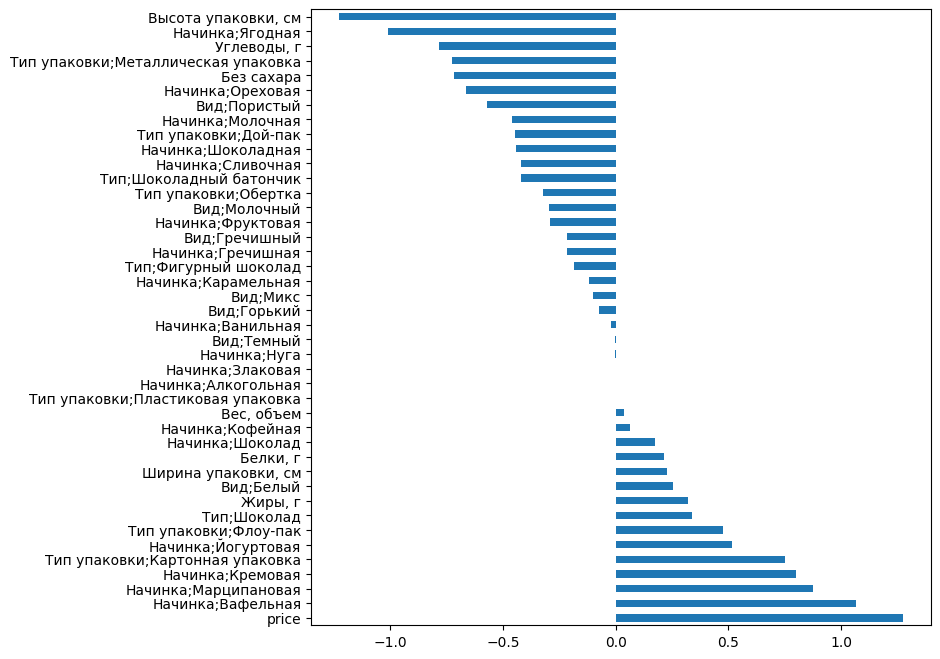

In [155]:
t1.sort_values(ascending=False).plot(kind='barh', figsize=(8, 8))


C:\Users\yaros\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\yaros\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

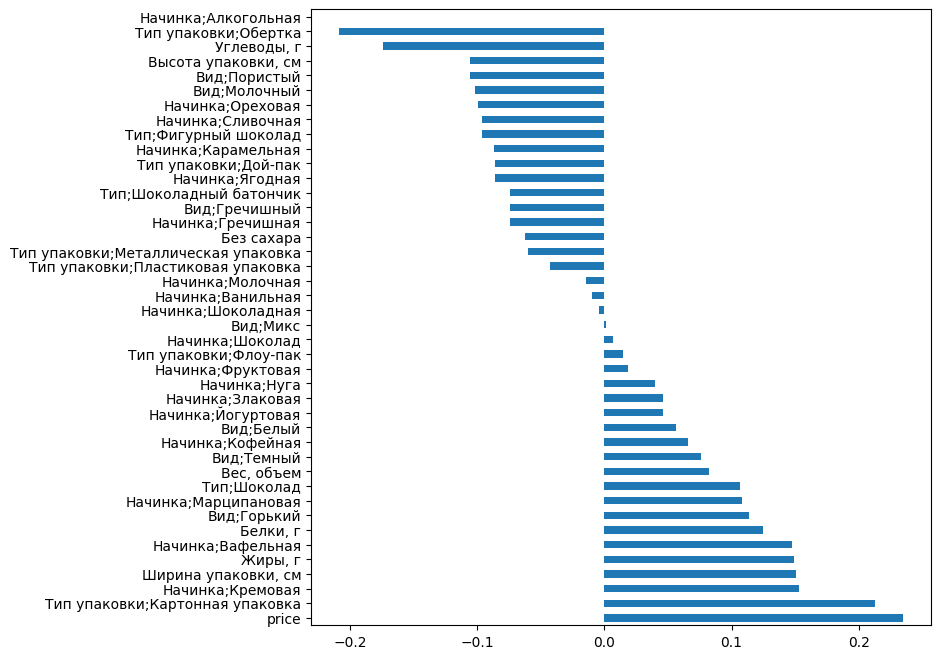

In [156]:
correlation_with_target = X_train.corrwith(y_train)
correlation_with_target.sort_values(ascending=False).plot(kind='barh', figsize=(8, 8))

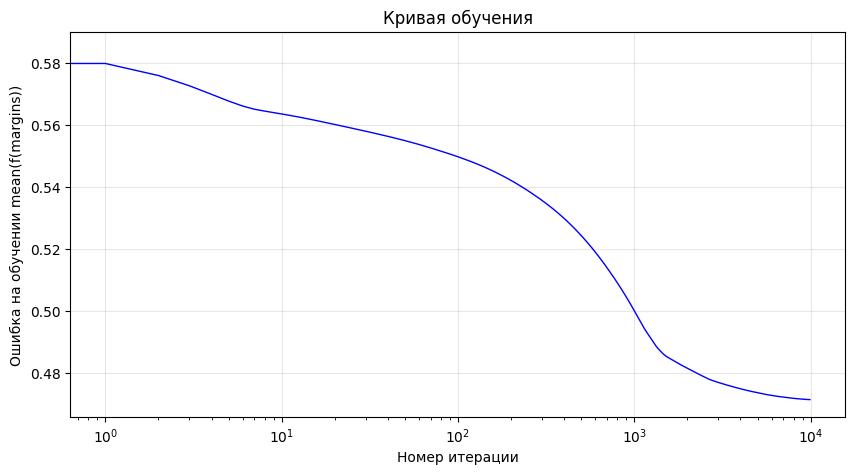

In [110]:
t1, l1 = gradient_descent(X_train, y_train, hinge, np.zeros(X_train.shape[1]), alpha=0.005, pho=0.2, iter=10000)
l1_smooth = np.convolve(l1, np.ones(100)/100, mode='valid')
plt.figure(figsize=(10, 5))
plt.plot(l1_smooth, color='blue', linewidth=1)
plt.xlabel("Номер итерации")
plt.ylabel("Ошибка на обучении mean(f(margins))")
plt.title("Кривая обучения")
plt.xscale("log")
plt.grid(True, alpha=0.3)
plt.show()

In [157]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(max_iter=1000)
perceptron.fit(X_train, y_train)
train_score = perceptron.score(X_train, y_train)
print(f"Точность Perceptron на обучении: {train_score:.3f}")

Точность Perceptron на обучении: 0.744


In [ ]:
t2, l2 = gradient_descent(X_train, y_train, logistic, np.zeros(X_train.shape[1]), alpha=0.005, pho=0.2, iter=10000)
t3, l3 = gradient_descent(X_train, y_train, exponential, np.zeros(X_train.shape[1]), alpha=0.005, pho=0.2, iter=10000)

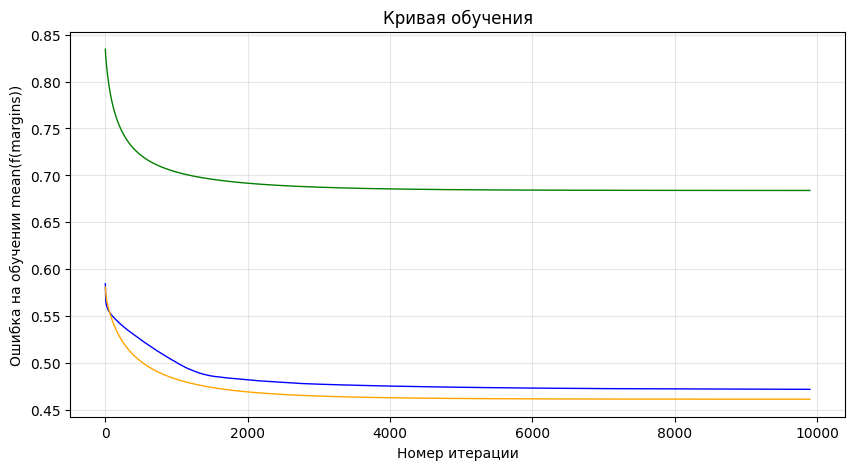

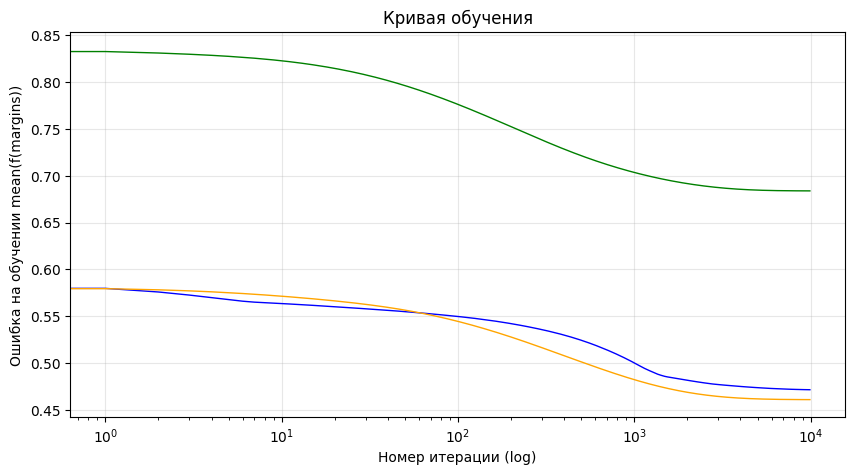

In [108]:
l1_smooth = np.convolve(l1, np.ones(100)/100, mode='valid') # Сглаживание нашей функции скользящим средним
l2_smooth = np.convolve(l2, np.ones(100)/100, mode='valid')
l3_smooth = np.convolve(l3, np.ones(100)/100, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(l1_smooth, color='blue', linewidth=1)
plt.plot(l2_smooth, color='orange', linewidth=1)
plt.plot(l3_smooth, color='green', linewidth=1)
plt.xlabel("Номер итерации")
plt.ylabel("Ошибка на обучении mean(f(margins))")
plt.title("Кривая обучения")
plt.grid(True, alpha=0.3)
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(l1_smooth, color='blue', linewidth=1)
plt.plot(l2_smooth, color='orange', linewidth=1)
plt.plot(l3_smooth, color='green', linewidth=1)
plt.xlabel("Номер итерации (log)")
plt.ylabel("Ошибка на обучении mean(f(margins))")
plt.title("Кривая обучения")
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.show()

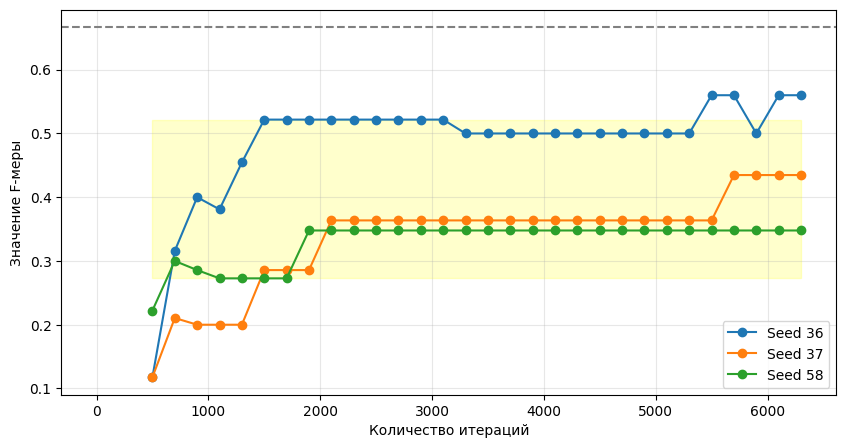

In [125]:
plt.figure(figsize=(10, 5))

steps = range(500, 6500, 200)
all_dots = []
for seed in [36, 37, 58]:
    dots_f = []
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    for step in steps:
        t1, l1 = gradient_descent(X_train, y_train, hinge, np.zeros(X_train.shape[1]), alpha=0.005, pho=0.2, iter=step)
        pred = X_test.dot(t1)
        pred = pred.map(lambda x: 1 if x > 0 else -1)
        dots_f.append(f_score(y_test, pred))
    all_dots += dots_f
    plt.plot(steps, dots_f, marker='o', label=f"Seed {seed}")

fsc = f_score(y_test, result)
plt.axline((0, fsc), (6000, fsc), color='gray', linestyle='--')
plt.fill_between(steps, np.percentile(all_dots, 10), np.percentile(all_dots, 95), color='yellow', alpha=0.2)
plt.xlabel("Количество итераций")
plt.ylabel("Значение F-меры")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

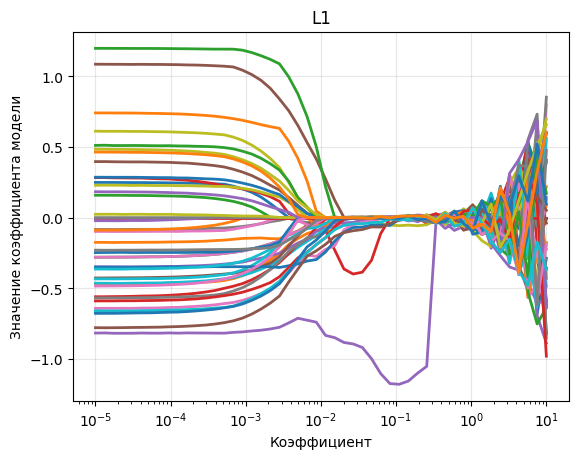

In [126]:
alphas = np.logspace(-5, 1, 50)

history = []

for alpha in alphas:
    t1, l1 = gradient_descent(X_train, y_train, hinge, np.zeros(X_train.shape[1]), alpha=alpha, pho=1)
    history.append(t1)

history = np.array(history)

for i in range(history.shape[1]):
    plt.plot(alphas, history[:, i], 
            linewidth=2, label=f'w_{i}')
    
    plt.xscale('log')
    plt.xlabel('Коэффициент')
    plt.ylabel('Значение коэффициента модели')
    plt.title('L1')
    plt.grid(True, alpha=0.3)



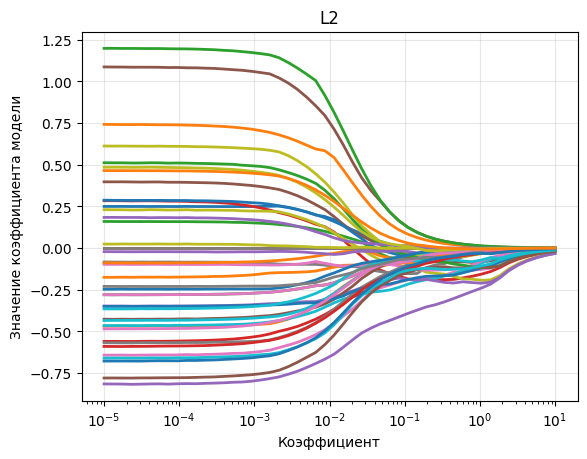

In [128]:
history = []
for alpha in alphas:
    t1, l1 = gradient_descent(X_train, y_train, hinge, np.zeros(X_train.shape[1]), alpha=alpha, pho=0)
    history.append(t1)

history = np.array(history)

for i in range(history.shape[1]):
    plt.plot(alphas, history[:, i], 
            linewidth=2, label=f'w_{i}')
    
    plt.xscale('log')
    plt.xlabel('Коэффициент')
    plt.ylabel('Значение коэффициента модели')
    plt.title('L2')
    plt.grid(True, alpha=0.3)